# Translink Chatbot

This chatbot is designed to help customers find transit-related information quickly and efficiently. At this stage, it provides information on the next bus's arrival time at a given stop and step-by-step directions from point A to point B. 

This project was done as part of a team effort at a one-day hackaton at [TransLink](www.translink.ca) and was awarded the "face-lift" prize along with two other projects. 

The chatbot is built using [Rasa](https://rasa.com/), an open-source library for conversational AI. The [Rasa Stack](https://rasa.com/products/rasa-stack/) consists of two main components: Rasa NLU and Rasa Core. The figure below decribes Rasa's ecosystem:

![](https://rasa.com/assets/img/rasa-ecosystem.png)


### Rasa NLU

Rasa NLU is a natural language understanding tool that allows machines to interpert natual language inputs in the form of text or speech. This is acheived by performing two tasks: intent classification and entity extraction. For example, a user input: "When is the next bus #8 coming at stop number 50234?" can be classified with an intent of checking the next bus's arrival time while the bus number and the stop number are the extracted entities. Rasa NLU provides a flexibile framework that allows the users to choose from pre-defined pipelines or defined their own custom pipelines. The [official documenation](https://rasa.com/docs/nlu/0.13.8/choosing_pipeline/) describes this in detail. In short, choosing an intent classification model or an entity extraction model is fairly straightforward. In this project, since the training data is relatively small (<1000 training examples) and we are developing the bot to operate in English (which is available as a [SpaCy](https://spacy.io/) langaue model), we chose the `spacy_sklearn` pipeline. SpaCy is an open-source library for advanced natural language processing (NLP) - it provides the underlying text processing capabilities for our chatbot. As described by its developers: "_SpaCy comes with pre-trained statistical models and word vectors, and currently supports tokenization for 30+ languages. It features the fastest syntactic parser in the world, convolutional neural network models for tagging, parsing and named entity recognition and easy deep learning integration. It's commercial open-source software, released under the MIT license._" An introduction to SpaCy can be found [here](https://spacy.io/usage/spacy-101#section-features). We specifically use the following Spacy's NLP tools: the language model represented by word vectors -  multi-dimensional meaning representations of words that allows us to determine how similar they are to each other, a tokenizer - which splits the sentence into tokens, and a featurizer - which transforms the sentence into a vector representation. We could use the named entity recognition (ner) pre-trained models, however, since we are dealing with custom entities, we trained a conditional random field model. We also trained a sklearn's support vector machine (SVM) model to classify users' intents. Rasa NLU provides a nice wrapper for these models as defined in the processing pipeline which defines how structured data is extracted from unstructured user inputs. 

### Rasa Core

Rasa Core is the dialogue engine that generates responses to users based on state of the coversation. Rasa Core achieves this by utilizing machine learning rather than state machines or rigid rules. This is how Rasa Core works:

![](https://rasa.com/docs/core/_images/rasa_arch_colour.png)

_The steps are (according to the [documentation](https://rasa.com/docs/core/architecture/)):_
1. The message is received and passed to an Interpreter, which converts it into a dictionary including the original text, the intent, and any entities that were found.
2. The Tracker is the object which keeps track of conversation state. It receives the info that a new message has come in.
3. The policy receives the current state of the tracker.
4. The policy chooses which action to take next.
5. The chosen action is logged by the tracker.
6. A response is sent to the user.

.... to be continued 

### Installation
You will need to install [Rasa NLU](https://rasa.com/docs/nlu/installation/), [Rasa Core](https://rasa.com/docs/core/installation/) and a [SpaCy language model](https://spacy.io/usage/models#section-install).

These resourses were very useful while working on this project:
1. https://rasa.com/docs/ ##Rasa documentation
2. https://spacy.io/ ##SpaCy documentation
3. https://github.com/RasaHQ/rasa-workshop-pydata-berlin ##Workshop at Pydata by @JustinaPetr 
4. https://github.com/RasaHQ/starter-pack-rasa-stack ##Rasa Stack starter-pack
5. https://developer.translink.ca/ServicesRtti/ApiReference ##TansLink next bus API documentation
6. https://developers.google.com/maps/documentation/directions/intro ##Google Maps directions API documentation

# Jupyter notebook configuration

In [428]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

# helper function to pretty print json
def pprint(o):
    print(json.dumps(o, indent=2))

# Import Rasa NLU, Rasa Core, and Spacy

In [67]:
import rasa_nlu
import rasa_core
import spacy

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("en")("Hello world!"))

rasa_nlu: 0.13.7 rasa_core: 0.9.6
Loading spaCy language model...
Hello world!


# Rasa NLU Model
We will build an NLU model as described above to teach our chatbot how to understand user inputs.

## Configuring the NLU model
We define the processing pipeline by specifiying the tools/models we will use to turnunstructured user inputs to  structured data. As we discussed above, we will use the `spacy_sklearn` pipeline.

In [404]:
config = """
language: "en"

pipeline: "spacy_sklearn"
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


## Creating training data for the NLU model


... details to be added

## Training the NLU model
We use the training data and the model configuration to develp the NLU model.

In [405]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

# loading the nlu training samples
training_data = load_data("data/data.json")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

2018-12-11 22:21:34 INFO     rasa_nlu.training_data.loading  - Training data format of data.json is rasa_nlu
2018-12-11 22:21:34 INFO     rasa_nlu.training_data.training_data  - Training data stats: 
	- intent examples: 322 (7 distinct intents)
	- Found intents: 'search_trip', 'search_bus_time', 'garbage', 'goodbye', 'thanks', 'affirm', 'greet'
	- entity examples: 133 (4 distinct entities)
	- found entities: 'location_start', 'location_end', 'stop_number', 'line_number'

2018-12-11 22:21:36 INFO     rasa_nlu.utils.spacy_utils  - Trying to load spacy model with name 'en'
2018-12-11 22:21:58 INFO     rasa_nlu.components  - Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
2018-12-11 22:21:58 INFO     rasa_nlu.model  - Starting to train component nlp_spacy
2018-12-11 22:22:01 INFO     rasa_nlu.model  - Finished training component.
2018-12-11 22:22:01 INFO     rasa_nlu.model  - Starting to train component tokenizer_spacy
2018-12-11 22:22:01 INFO     rasa_nlu.model  - Finished train

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.8s finished
2018-12-11 22:22:05 INFO     rasa_nlu.model  - Finished training component.
2018-12-11 22:22:13 INFO     rasa_nlu.model  - Successfully saved model into '/Users/mohamedsalahmahmoud/Documents/transitchatbot/models/nlu/default/current'


## Evaluating the model

2018-12-11 22:22:32 INFO     rasa_nlu.components  - Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
2018-12-11 22:22:32 INFO     rasa_nlu.training_data.loading  - Training data format of data.json is rasa_nlu
2018-12-11 22:22:32 INFO     rasa_nlu.training_data.training_data  - Training data stats: 
	- intent examples: 322 (7 distinct intents)
	- Found intents: 'search_trip', 'search_bus_time', 'garbage', 'goodbye', 'thanks', 'affirm', 'greet'
	- entity examples: 133 (4 distinct entities)
	- found entities: 'location_start', 'location_end', 'stop_number', 'line_number'

2018-12-11 22:22:39 INFO     rasa_nlu.evaluate  - Intent evaluation results:
2018-12-11 22:22:39 INFO     rasa_nlu.evaluate  - Intent Evaluation: Only considering those 322 examples that have a defined intent out of 322 examples
2018-12-11 22:22:39 INFO     rasa_nlu.evaluate  - F1-Score:  0.9969007922240657
2018-12-11 22:22:39 INFO     rasa_nlu.evaluate  - Precision: 0.9969519208649644
2018-12-11 22:22:39 INFO 

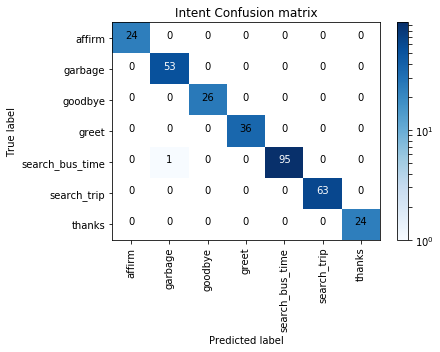

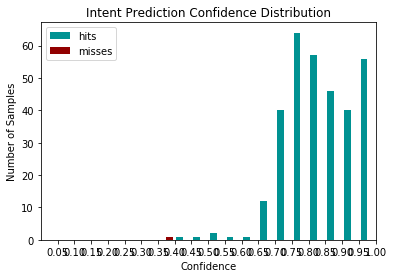

2018-12-11 22:22:41 INFO     rasa_nlu.evaluate  - Entity evaluation results:
2018-12-11 22:22:41 INFO     rasa_nlu.evaluate  - Evaluation for entity extractor: ner_crf 
2018-12-11 22:22:41 INFO     rasa_nlu.evaluate  - F1-Score:  0.9975254750938358
2018-12-11 22:22:41 INFO     rasa_nlu.evaluate  - Precision: 0.9975499653354858
2018-12-11 22:22:41 INFO     rasa_nlu.evaluate  - Accuracy:  0.997513983840895
2018-12-11 22:22:41 INFO     rasa_nlu.evaluate  - Classification report: 
                precision    recall  f1-score   support

   line_number       1.00      1.00      1.00        52
  location_end       0.97      0.99      0.98        99
location_start       1.00      1.00      1.00        92
     no_entity       1.00      1.00      1.00      1325
   stop_number       1.00      1.00      1.00        41

   avg / total       1.00      1.00      1.00      1609



In [406]:
#on the training data
from rasa_nlu.evaluate import run_evaluation

run_evaluation("data/data.json", model_directory)

In [407]:
#using cross validation
import sys
python = sys.executable

!{python} -m rasa_nlu.evaluate \
    --data data/data.json \
    --config config.yml \
    --mode crossvalidation

/Users/mohamedsalahmahmoud/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
2018-12-11 22:22:45 INFO     rasa_nlu.training_data.loading  - Training data format of data.json is rasa_nlu
2018-12-11 22:22:45 INFO     rasa_nlu.training_data.training_data  - Training data stats: 
	- intent examples: 322 (7 distinct intents)
	- Found intents: 'search_bus_time', 'affirm', 'goodbye', 'thanks', 'search_trip', 'garbage', 'greet'
	- entity examples: 133 (4 distinct entities)
	- found entities: 'stop_number', 'location_start', 'location_end', 'line_number'

2018-12-11 22:22:45 INFO     rasa_nlu.training_data.training_data  - Training data stats: 
	- intent examples: 322 (7 distinct intents)
	- Found intents: 'search_bus_time', 'affirm', 'goodbye', 

2018-12-11 22:23:37 INFO     rasa_nlu.model  - Finished training component.
2018-12-11 22:23:37 INFO     rasa_nlu.model  - Starting to train component tokenizer_spacy
2018-12-11 22:23:37 INFO     rasa_nlu.model  - Finished training component.
2018-12-11 22:23:37 INFO     rasa_nlu.model  - Starting to train component intent_featurizer_spacy
2018-12-11 22:23:37 INFO     rasa_nlu.model  - Finished training component.
2018-12-11 22:23:37 INFO     rasa_nlu.model  - Starting to train component intent_entity_featurizer_regex
2018-12-11 22:23:37 INFO     rasa_nlu.model  - Finished training component.
2018-12-11 22:23:37 INFO     rasa_nlu.model  - Starting to train component ner_crf
2018-12-11 22:23:37 INFO     rasa_nlu.model  - Finished training component.
2018-12-11 22:23:37 INFO     rasa_nlu.model  - Starting to train component ner_synonyms
2018-12-11 22:23:37 INFO     rasa_nlu.model  - Finished training component.
2018-12-11 22:23:37 INFO     rasa_nlu.model  - Starting to train component in

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.6s finished
2018-12-11 22:25:13 INFO     rasa_nlu.model  - Finished training component.
2018-12-11 22:25:23 INFO     rasa_nlu.training_data.training_data  - Training data stats: 
	- intent examples: 293 (7 distinct intents)
	- Found intents: 'search_bus_time', 'affirm', 'goodbye', 'thanks', 'search_trip', 'garbage', 'greet'
	- entity examples: 120 (4 distinct entities)
	- found entities: 'stop_number', 'location_start', 'location_end', 'line_number'

2018-12-11 22:25:23 INFO     rasa_nlu.training_data.training_data  - Training data stats: 
	- intent examples: 29 (7 distinct intents)
	- Found intents: 'search_bus_time', 'affirm', 'goodbye', 'thanks', 'search_trip', 'greet', 'garbage'
	- entity examples: 13 (4 distinct entities)
	- found entities: 'stop_number', 'location_start', 'location_end', 'line_number'

2018-12-11 22:25:23 INFO     rasa_nlu.model  - Starting to train component nlp_spacy
2018-12-11 22:25:29 INFO     rasa_nlu

2018-12-11 22:26:02 INFO     rasa_nlu.model  - Finished training component.
2018-12-11 22:26:02 INFO     rasa_nlu.model  - Starting to train component ner_synonyms
2018-12-11 22:26:02 INFO     rasa_nlu.model  - Finished training component.
2018-12-11 22:26:02 INFO     rasa_nlu.model  - Starting to train component intent_classifier_sklearn
Fitting 4 folds for each of 6 candidates, totalling 24 fits
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.6s finished
2018-12-11 22:26:04 INFO     rasa_nlu.model  - Finished training component.
2018-12-11 22:26:13 INFO     rasa_nlu.training_data.training_data  - Training data stats: 
	- intent examples: 293 (7 distinct intents)
	- Found intents: 'search_bus_time', 'affirm', 'goodbye', 'thanks', 'search_trip', 'greet', 'garbage'
	- entity examples: 123 (4 distinct entities)
	- found entities: 'stop_number', 'location_start', 'location_end', 'line_number'

2018-12-11 22:26:13 INFO     rasa_nlu.training_data.training_data  - Training data sta

## Testing the model

In [411]:
pprint(interpreter.parse("how can I go to 41 and 22 from 161 and 4th west?"))
#pprint(interpreter.parse("How can I go from Metrotown to Rogers Arena?"))

{
  "intent": {
    "name": "search_trip",
    "confidence": 0.8485107373907249
  },
  "entities": [
    {
      "start": 16,
      "end": 25,
      "value": "41 and 22",
      "entity": "location_end",
      "confidence": 0.6891247345938672,
      "extractor": "ner_crf"
    },
    {
      "start": 31,
      "end": 47,
      "value": "161 and 4th west",
      "entity": "location_start",
      "confidence": 0.5595530674963319,
      "extractor": "ner_crf"
    }
  ],
  "intent_ranking": [
    {
      "name": "search_trip",
      "confidence": 0.8485107373907249
    },
    {
      "name": "search_bus_time",
      "confidence": 0.07388938501363305
    },
    {
      "name": "goodbye",
      "confidence": 0.0286960981144374
    },
    {
      "name": "garbage",
      "confidence": 0.025418811503305206
    },
    {
      "name": "greet",
      "confidence": 0.010043720892750777
    },
    {
      "name": "affirm",
      "confidence": 0.007177956157897547
    },
    {
      "name": "thanks",


# Rasa Core Model

## Configure the domain file

In [412]:
domain_yml = """
intents:
- greet
- affirm
- thanks
- goodbye
- search_bus_time
- search_trip
- garbage

slots:
  line_number:
    type: text
    
  stop_number:
    type: text
    
  location_start:
    type: text
  
  location_end:
    type: text    
    
entities:
- line_number
- stop_number
- location_start
- location_end

actions:
- utter_greet
- utter_goodbye
- utter_thanks
- utter_garbage
- utter_affirm
- utter_ask_line_number
- utter_ask_stop_number
- utter_ask_location_start
- utter_ask_location_end
- __main__.NextbusApiAction
- __main__.TripApiAction

templates:
  utter_greet:
  - text: "Hey! How can help you?"
  - text: "Hello! How can help you?"
  - text: "Hi, traveller! How can help you?"
  - text: "Greetings, welcome to the future! How can help you?"
  
  utter_affirm:
  - text: "Great!"
  - text: "Awesome!"
  - text: "Perfect!"

  utter_thanks:
  - text: "You are very welcome!"
  - text: "Anytime!"
  - text: "My pleasure!"
  
  utter_goodbye:
  - text: "Bye"
  - text: "See you soon!"
  - text: "Goodbye!"
  - text: "Safe trip!"
  - text: "Happy travelling!"

  utter_garbage:
  - text: "I am not sure what you are aiming for. Please give me more specific information such as the stop number and the bus line or the origin and destination for your trip."
  - text: "Huh, come again?! Please give me more specific information such as the stop number and the bus line or the origin and destination for your trip."
  - text: "Hmm ... not sure what you're asking? Please provide more specific information such as the stop number and the bus line or the origin and destination for your trip."
  - text: "Hmm ... I am still learning! Can you rephrase that please? It's easier for me if you give me specific information such as the stop number and the bus line or the origin and destination for your trip."
  - text: "What do you mean? It'd be easier for me if you included specific information such as the stop number and the bus line or the origin and destination for your trip."
  - text: "Well .. it depends! Can you be more specific? Please provide me with the stop number and the bus line or the origin and destination for your trip."
  
  utter_ask_line_number:
  - text: "Sure, what is the bus number? For example, you can say: 'Bus number 8'"
  - text: "I need the bus number. For example, you can say: 'Bus number 8'"
  - text: "Which bus line do you plan on taking? For example, you can say: 'Bus number 8'"
    
  utter_ask_stop_number:
  - text: "Sure, what is the stop number? For example, you can say: 'Stop number 50234'"
  - text: "I can help you with that! I need the stop number. For example, you can say: 'Stop number 50234'"
  - text: "Which stop number? For example, you can say: 'Stop number 50234'"
  
  utter_ask_location_start:
  - text: "Sure, what is the start address?"
  - text: "I can help you with that! I just need to know where you're trip is starting from."
  - text: "I can help you with that! I need the starting address."
    
  utter_ask_location_end:
  - text: "Sure, what is the address of your destination?"
  - text: "I can help you with that! I just need the location or address of where you're going."
  - text: "To which destination?"
"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


## Actions

### Action1: NextBus API

In [419]:
from rasa_core.actions import Action
from rasa_core.events import SlotSet

import requests
import xml.etree.ElementTree as ET
import pandas as pd
import datetime

class NextbusApiAction(Action):
    def name(self):
        return "action_next_bus"

    def run(self, dispatcher, tracker, domain):
        
        with open('keys/nextbus_api_key.txt', 'r') as myfile:
            nextbus_api_key = myfile.read()
            
        line_number = tracker.get_slot('line_number')
        stop_number = tracker.get_slot('stop_number')
        
        req = 'http://api.translink.ca/rttiapi/v1/stops/'+stop_number+'/estimates?apikey='+nextbus_api_key+'&routeNo='+line_number
        resp = requests.get(req)
        root = ET.fromstring(resp.text)
        
        xmlstr = str(ET.tostring(root, encoding='utf8', method='text'))

        if '200' in str(resp): #valid response code
            nbs = []
            for nb in root:
                r = nb.find('RouteNo').text
                for s in nb.find('Schedules'):
                    t = s.find('ExpectedLeaveTime').text
                    nbs.append((r,t))

            nbs=pd.DataFrame(nbs,columns=('route','lvtime'))
            nbs.sort_values(['route','lvtime'])

            lvtime = nbs.iloc[0].lvtime
            
            dispatcher.utter_message("Your next bus will arrive at: {}".format(lvtime))
        else:
            dispatcher.utter_message('Hmm ... something went wrong :(\nInvalid bus number and/or stop number combination specified. Make sure that this bus number runs at the stop number you specified.\nPlease use a valid bus number is 3 digits, for example 003, 590. For community shuttle or night bus routes, please use "C" or "N" followed by up to 2 digits, i.e. N9, C22')
            

### Action2: GoogleMaps API

In [420]:
from rasa_core.actions import Action
from rasa_core.events import SlotSet

import json
import urllib.request, urllib.parse, urllib.error
import time
import re
from IPython.core.display import display, HTML

#define regex to strip postal code from address
postalcode_re = re.compile(r'[A-Z]\d[A-Z] *\d[A-Z]\d')
def remove_postalcode(text):
    return postalcode_re.sub('', text)

#define regex to strip html tags from instructions
htmltags_re = re.compile(r'<[^>]+>')
def remove_htmltags(text):
    return htmltags_re.sub(' ', text)

#base url for api call
url_base = 'https://maps.googleapis.com/maps/api/directions/json?'

#mode of travel
mode = 'transit'

#set departure time as now -- can be changed later to provide directions in the future
departure_time = int(time.time())

class TripApiAction(Action):
    def name(self):
        return "action_trip"

    def run(self, dispatcher, tracker, domain):
        
        with open('keys/googlemaps_api_key.txt', 'r') as myfile:
            googlemaps_api_key = myfile.read()
        
        location_start = tracker.get_slot('location_start')
        location_end = tracker.get_slot('location_end')
        
        try:
            location_start = location_start + ' bc, Canada'
        except:
            pass
        
        try:
            location_end = location_end + ' bc, Canada'
        except:
            pass
        
        def direction(location_start, location_end, departure_time):
            '''
            Function to retreive Google Maps directions based on start and end locations, mode, and departure time.
            Mode is defined as transit and departure time is set to the current time of the request.
            '''
            #define query arguments
            query_args = {
                    'origin':location_start,
                    'destination':location_end,
                    'mode': mode,
                    'departure_time': departure_time
            }

            #encode the arguments
            encoded_args = urllib.parse.urlencode(query_args)

            #create the url with the encoded arguments and api key
            url = url_base + encoded_args
            encoded_url= url+'&key='+googlemaps_api_key

            #make the request and save the json response
            resp=urllib.request.urlopen(encoded_url).read()
            data = json.loads(resp)
            return(data)

        if location_start == '' or location_end == '' or location_start is None or location_end is None or location_start == location_end:
            print("Hmm ... Something went wrong! I can't find the location :(")
        else:
            data = direction(location_start, location_end, departure_time)

            #fallback if the resquest failed
            if data['status'] != 'OK': 
                instructions = 'No route found! Please give me more specific information about the locations of your trip origin and destination.'
                dispatcher.utter_message(instructions)
            else:
                #grab some information form the json response
                start_address = data['routes'][0]['legs'][0]['start_address']
                end_address = data['routes'][0]['legs'][0]['end_address']
                start_address = remove_postalcode(start_address).replace(', BC', '').replace(', Canada', '')
                end_address = remove_postalcode(end_address).replace(', BC', '').replace(', Canada', '')

                #create a map url
                map_url = 'https://www.google.com/maps?'+urllib.parse.urlencode({'saddr': start_address, 'daddr': end_address, 'dirflg': 'r'})

                travel_time = data['routes'][0]['legs'][0]['duration']['text']
                
                if travel_time == 0:
                    arrival_time = departure_time
                else:
                    arrival_time = data['routes'][0]['legs'][0]['arrival_time']['text']

                #grab instructions (step-by-step directions)
                #html_instructions can be found under routes/legs/steps or routes/legs/steps/steps
                #loop through all the steps and save instructions
                instructions = []
                num_iters = max(len(data['routes'][0]['legs'][0]['steps']), len(data['routes'][0]['legs'][0]['steps'][0]['steps']))
                for i in range (0, num_iters):
                    try:
                        instructions.append(remove_postalcode(data['routes'][0]['legs'][0]['steps'][i]['html_instructions'].replace('Subway towards', 'Take SkyTrain')).replace(', BC', '').replace(', Canada', '').replace('U-turn', 'turn'))
                    except:
                        pass
                    for j in range (0, num_iters):
                        try:
                            instructions.append(remove_postalcode(remove_htmltags(data['routes'][0]['legs'][0]['steps'][i]['steps'][j]['html_instructions'])).replace(', BC', '').replace(', Canada', '').replace('U-turn', 'turn'))
                        except:
                            pass
                        
                dispatcher.utter_message("Here are the directions from {} to {}:\n{}\n\nIf you leave now, you should arrive at {} by {}. Your trip should take around {}.\n".format(start_address, end_address, ("\n".join(instructions)), end_address, arrival_time, travel_time))
                dispatcher.utter_message("Click on the following link to view the direction on Google Maps:\n{}".format(map_url))
                #display(HTML("<a href="+map_url+">Google Maps Directions</a>"))

## Training The Dialogue Model

In [415]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

# this will catch predictions the model isn't very certain about
fallback = FallbackPolicy(fallback_action_name="utter_garbage",
                          core_threshold=0.1,
                          nlu_threshold=0.1)

agent = Agent('domain.yml', policies=[MemoizationPolicy(max_history=2), KerasPolicy(), fallback])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')


agent.train(
    training_data,
    epochs = 200,
    batch_size = 32,
    validation_split = 0.2
)

agent.persist('models/dialogue')

Processed Story Blocks: 100%|██████████| 58/58 [00:01<00:00, 40.81it/s, # trackers=16]
2018-12-11 22:31:22 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 2656/2656 [05:28<00:00,  9.30it/s, # actions=337]
2018-12-11 22:36:50 INFO     rasa_core.featurizers  - Created 337 action examples.
Processed actions: 337it [00:01, 248.39it/s, # examples=321]
2018-12-11 22:36:52 INFO     rasa_core.policies.memoization  - Memorized 321 unique action examples.
2018-12-11 22:36:52 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 2656/2656 [06:23<00:00,  9.08it/s, # actions=1379]
2018-12-11 22:43:15 INFO     rasa_core.featurizers  - Created 1379 action examples.
2018-12-11 22:43:18 INFO     rasa_core.policies.keras_policy  - Fitting model with 1379 total samples and a v

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_13 (Masking)         (None, 5, 28)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                7808      
_________________________________________________________________
dense_13 (Dense)             (None, 13)                429       
_________________________________________________________________
activation_13 (Activation)   (None, 13)                0         
Total params: 8,237
Trainable params: 8,237
Non-trainable params: 0
_________________________________________________________________
Train on 1103 samples, validate on 276 samples
Epoch 1/200
1103/1103 [==============================] - 8s 7ms/step - loss: 2.2008 - acc: 0.4397 - val_loss: 1.9104 - val_acc: 0.5109
Epoch 2/200
1103/1103 [==============================] - 1s 563us/step - loss: 1.8739 - ac

Epoch 54/200
1103/1103 [==============================] - 1s 513us/step - loss: 0.0960 - acc: 0.9746 - val_loss: 0.0444 - val_acc: 1.0000
Epoch 55/200
1103/1103 [==============================] - 1s 470us/step - loss: 0.0820 - acc: 0.9846 - val_loss: 0.0466 - val_acc: 0.9964
Epoch 56/200
1103/1103 [==============================] - 0s 383us/step - loss: 0.0831 - acc: 0.9837 - val_loss: 0.0471 - val_acc: 0.9928
Epoch 57/200
1103/1103 [==============================] - 0s 367us/step - loss: 0.0894 - acc: 0.9819 - val_loss: 0.0392 - val_acc: 0.9964
Epoch 58/200
1103/1103 [==============================] - 0s 396us/step - loss: 0.0730 - acc: 0.9846 - val_loss: 0.0362 - val_acc: 1.0000
Epoch 59/200
1103/1103 [==============================] - 0s 372us/step - loss: 0.0799 - acc: 0.9801 - val_loss: 0.0369 - val_acc: 1.0000
Epoch 60/200
1103/1103 [==============================] - 0s 317us/step - loss: 0.0662 - acc: 0.9837 - val_loss: 0.0349 - val_acc: 1.0000
Epoch 61/200
1103/1103 [==========

Epoch 113/200
1103/1103 [==============================] - 0s 379us/step - loss: 0.0366 - acc: 0.9900 - val_loss: 0.0108 - val_acc: 0.9964
Epoch 114/200
1103/1103 [==============================] - 0s 358us/step - loss: 0.0308 - acc: 0.9937 - val_loss: 0.0062 - val_acc: 1.0000
Epoch 115/200
1103/1103 [==============================] - 0s 346us/step - loss: 0.0337 - acc: 0.9918 - val_loss: 0.0087 - val_acc: 1.0000
Epoch 116/200
1103/1103 [==============================] - 0s 387us/step - loss: 0.0282 - acc: 0.9937 - val_loss: 0.0130 - val_acc: 1.0000
Epoch 117/200
1103/1103 [==============================] - 0s 432us/step - loss: 0.0314 - acc: 0.9927 - val_loss: 0.0077 - val_acc: 1.0000
Epoch 118/200
1103/1103 [==============================] - 0s 430us/step - loss: 0.0376 - acc: 0.9900 - val_loss: 0.0077 - val_acc: 1.0000
Epoch 119/200
1103/1103 [==============================] - 0s 325us/step - loss: 0.0334 - acc: 0.9918 - val_loss: 0.0078 - val_acc: 1.0000
Epoch 120/200
1103/1103 [==

Epoch 172/200
1103/1103 [==============================] - 0s 356us/step - loss: 0.0228 - acc: 0.9937 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 173/200
1103/1103 [==============================] - 0s 331us/step - loss: 0.0121 - acc: 0.9982 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 174/200
1103/1103 [==============================] - 0s 321us/step - loss: 0.0133 - acc: 0.9973 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 175/200
1103/1103 [==============================] - 0s 326us/step - loss: 0.0267 - acc: 0.9937 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 176/200
1103/1103 [==============================] - 0s 302us/step - loss: 0.0202 - acc: 0.9927 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 177/200
1103/1103 [==============================] - 0s 314us/step - loss: 0.0236 - acc: 0.9918 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 178/200
1103/1103 [==============================] - 0s 295us/step - loss: 0.0236 - acc: 0.9937 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 179/200
1103/1103 [==

2018-12-11 22:45:01 INFO     rasa_core.policies.keras_policy  - Done fitting keras policy model
2018-12-11 22:45:01 INFO     rasa_core.agent  - Model directory models/dialogue exists and contains old model files. All files will be overwritten.
2018-12-11 22:45:14 INFO     rasa_core.agent  - Persisted model to '/Users/mohamedsalahmahmoud/Documents/transitchatbot/models/dialogue'


## Evaluating the model

Processed Story Blocks: 100%|██████████| 58/58 [00:00<00:00, 140455.91it/s]
2018-12-11 22:45:30 INFO     rasa_core.evaluate  - Evaluating 54 stories
Progress:
 41%|████      | 22/54 [00:15<00:10,  3.02it/s]2018-12-11 22:45:45 ERROR    rasa_core.processor  - Encountered an exception while running action 'action_trip'. Bot will continue, but the actions events are lost. Make sure to fix the exception in your custom code.
2018-12-11 22:45:45 ERROR    rasa_core.processor  - [Errno 2] No such file or directory: 'googlemaps_api_key.txt'
Traceback (most recent call last):
  File "/Users/mohamedsalahmahmoud/anaconda3/lib/python3.6/site-packages/rasa_core/processor.py", line 302, in _run_action
    events = action.run(dispatcher, tracker, self.domain)
  File "<ipython-input-414-88e6fdc1eba9>", line 39, in run
    with open('googlemaps_api_key.txt', 'r') as myfile:
FileNotFoundError: [Errno 2] No such file or directory: 'googlemaps_api_key.txt'
 44%|████▍     | 24/54 [00:15<00:07,  3.76it/s]2018

2018-12-11 22:45:48 ERROR    rasa_core.processor  - Encountered an exception while running action 'action_trip'. Bot will continue, but the actions events are lost. Make sure to fix the exception in your custom code.
2018-12-11 22:45:48 ERROR    rasa_core.processor  - [Errno 2] No such file or directory: 'googlemaps_api_key.txt'
Traceback (most recent call last):
  File "/Users/mohamedsalahmahmoud/anaconda3/lib/python3.6/site-packages/rasa_core/processor.py", line 302, in _run_action
    events = action.run(dispatcher, tracker, self.domain)
  File "<ipython-input-414-88e6fdc1eba9>", line 39, in run
    with open('googlemaps_api_key.txt', 'r') as myfile:
FileNotFoundError: [Errno 2] No such file or directory: 'googlemaps_api_key.txt'
 89%|████████▉ | 48/54 [00:17<00:00, 10.39it/s]2018-12-11 22:45:48 ERROR    rasa_core.processor  - Encountered an exception while running action 'action_trip'. Bot will continue, but the actions events are lost. Make sure to fix the exception in your custom

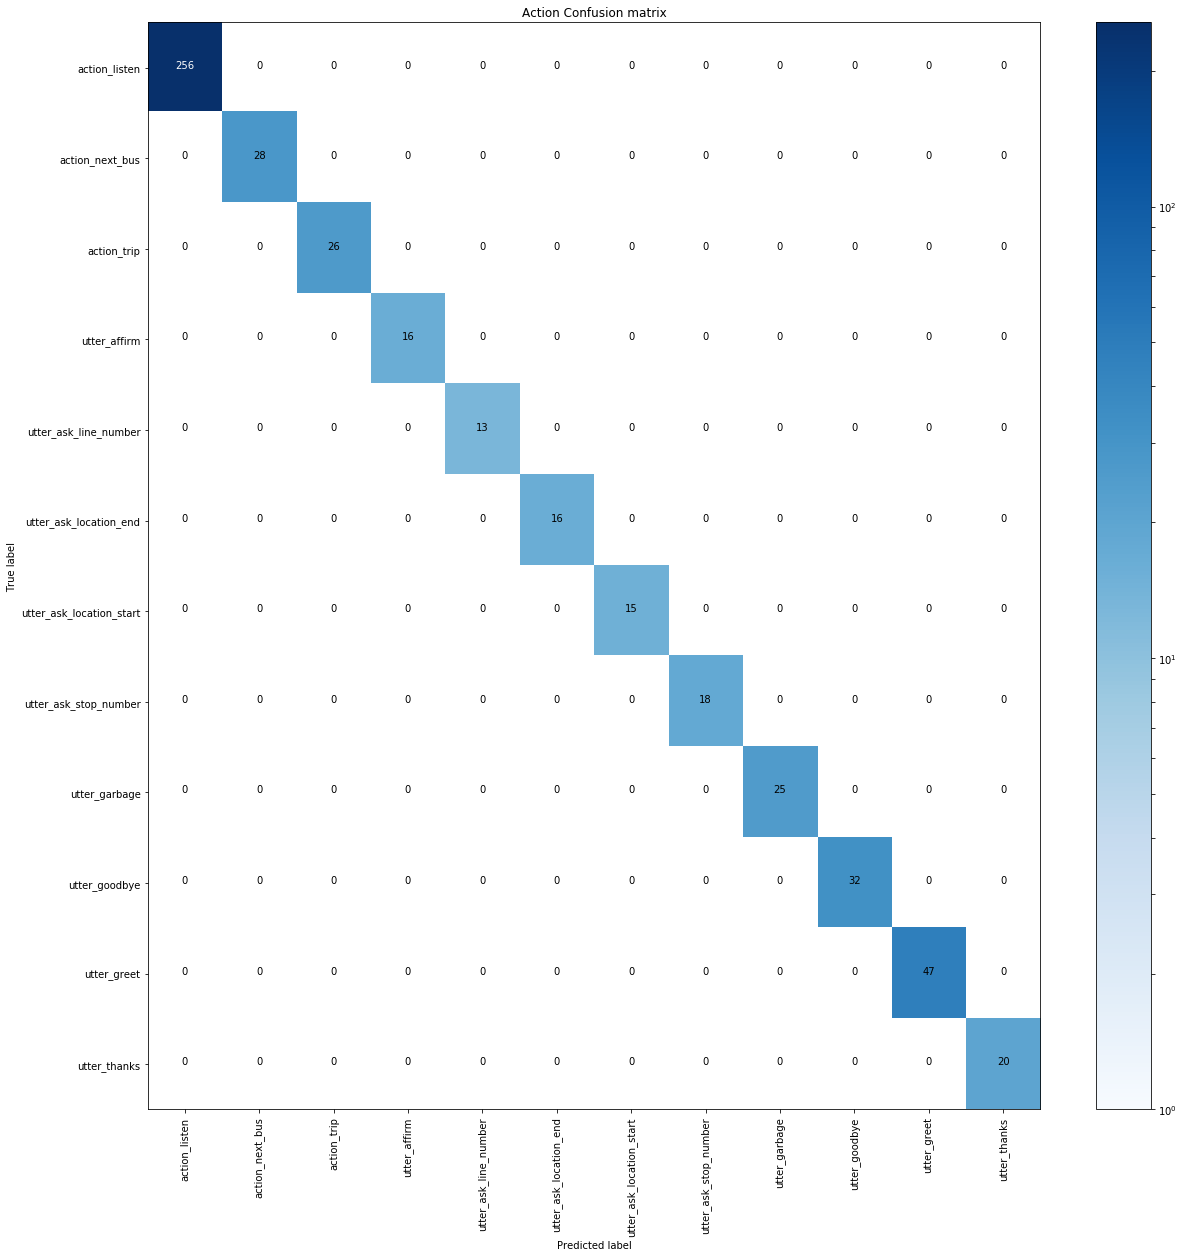

In [416]:
### Evaluation of the dialogue model on the *traning data*
from rasa_core.evaluate import run_story_evaluation

run_story_evaluation("data/stories.md", "models/dialogue", 
                     nlu_model_path=None, 
                     max_stories=None, 
                     out_file_plot="/models/dialogue/story_eval.pdf")

## Loading the model

In [421]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

2018-12-11 22:52:52 INFO     rasa_nlu.components  - Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


## Testing the model

In [429]:
print("TransLink's Trip Planner bot is ready to serve you! Type your messages here or send 'stop' to end the session.")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])

TransLink's Trip Planner bot is ready to serve you! Type your messages here or send 'stop' to end the session.
hi
Greetings, welcome to the future! How can help you?
what is the weather tomorrow?
Hmm ... not sure what you're asking? Please provide more specific information such as the stop number and the bus line or the origin and destination for your trip.
ok .. when is bus 8 coming?
Which stop number? For example, you can say: 'Stop number 50234'
stop 50234
Your next bus will arrive at: 12:05am
awesome!
Perfect!
byee
Bye
stop


# Interactive Training Session

In [235]:
# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function
# from __future__ import unicode_literals

# import logging

# from rasa_core import utils
# from rasa_core.agent import Agent
# from rasa_core.channels.console import ConsoleInputChannel
# from rasa_core.interpreter import RasaNLUInterpreter
# from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy

# logger = logging.getLogger(__name__)


# def run_online(input_channel, interpreter,
#                           domain_file="domain.yml",
#                           training_data_file='stories.md'):
#     fallback = FallbackPolicy(fallback_action_name="utter_garbage",
#                           core_threshold=0.1,
#                           nlu_threshold=0.1)

#     agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy(), fallback], interpreter = interpreter)

#     training_data = agent.load_data(training_data_file)
#     agent.train_online(training_data,
#                        input_channel=input_channel,
#                        epochs=200)

#     return agent


# utils.configure_colored_logging(loglevel="INFO")
# nlu_interpreter = RasaNLUInterpreter('models/nlu/default/current')
# run_online(ConsoleInputChannel(), nlu_interpreter)

2018-12-09 22:09:24 INFO     rasa_nlu.components  - Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
Processed Story Blocks: 100%|██████████| 51/51 [00:03<00:00, 15.30it/s, # trackers=14]
2018-12-09 22:09:30 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 1844/1844 [02:57<00:00, 10.42it/s, # actions=812]
2018-12-09 22:12:27 INFO     rasa_core.featurizers  - Created 812 action examples.
Processed actions: 812it [00:02, 293.58it/s, # examples=734]
2018-12-09 22:12:30 INFO     rasa_core.policies.memoization  - Memorized 734 unique action examples.
2018-12-09 22:12:30 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 1844/1844 [04:11<00:00, 15.39it/s, # actions=812]
2018-12-09 22:16:41 INFO     rasa_core.featurizers  - Created 812 action examples.
2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_6 (Masking)          (None, 5, 28)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                7808      
_________________________________________________________________
dense_6 (Dense)              (None, 13)                429       
_________________________________________________________________
activation_6 (Activation)    (None, 13)                0         
Total params: 8,237
Trainable params: 8,237
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
812/812 [==============================] - 2s 3ms/step - loss: 2.3535 - acc: 0.3732
Epoch 2/200
812/812 [==============================] - 0s 249us/step - loss: 2.1170 - acc: 0.4138
Epoch 3/200
812/812 [==============================] - 0s 232us/step - loss: 2

812/812 [==============================] - 0s 284us/step - loss: 0.1983 - acc: 0.9187
Epoch 76/200
812/812 [==============================] - 0s 349us/step - loss: 0.2024 - acc: 0.9200
Epoch 77/200
812/812 [==============================] - 0s 359us/step - loss: 0.2024 - acc: 0.9273
Epoch 78/200
812/812 [==============================] - 0s 296us/step - loss: 0.2039 - acc: 0.9212
Epoch 79/200
812/812 [==============================] - 0s 313us/step - loss: 0.2062 - acc: 0.9138
Epoch 80/200
812/812 [==============================] - 0s 304us/step - loss: 0.2001 - acc: 0.9150
Epoch 81/200
812/812 [==============================] - 0s 286us/step - loss: 0.1997 - acc: 0.9286
Epoch 82/200
812/812 [==============================] - 0s 422us/step - loss: 0.1903 - acc: 0.9212
Epoch 83/200
812/812 [==============================] - 0s 314us/step - loss: 0.1871 - acc: 0.9200
Epoch 84/200
812/812 [==============================] - 0s 293us/step - loss: 0.2027 - acc: 0.9150
Epoch 85/200
812/812 [=

812/812 [==============================] - 0s 251us/step - loss: 0.1355 - acc: 0.9372
Epoch 158/200
812/812 [==============================] - 0s 246us/step - loss: 0.1219 - acc: 0.9507
Epoch 159/200
812/812 [==============================] - 0s 242us/step - loss: 0.1323 - acc: 0.9470
Epoch 160/200
812/812 [==============================] - 0s 284us/step - loss: 0.1378 - acc: 0.9397
Epoch 161/200
812/812 [==============================] - 0s 350us/step - loss: 0.1183 - acc: 0.9372
Epoch 162/200
812/812 [==============================] - 0s 281us/step - loss: 0.1301 - acc: 0.9323
Epoch 163/200
812/812 [==============================] - 0s 321us/step - loss: 0.1169 - acc: 0.9421
Epoch 164/200
812/812 [==============================] - 0s 281us/step - loss: 0.1302 - acc: 0.9323
Epoch 165/200
812/812 [==============================] - 0s 243us/step - loss: 0.1238 - acc: 0.9384
Epoch 166/200
812/812 [==============================] - 0s 256us/step - loss: 0.1350 - acc: 0.9298
Epoch 167/200


2018-12-09 22:17:32 INFO     rasa_core.policies.keras_policy  - Done fitting keras policy model


Bot loaded. Type a message and press enter: 
hi
------
Chat history:

	bot did:	None

	bot did:	action_listen

	user said:	hi

		 whose intent is:	greet

we currently have slots: line_number: None, location_end: None, location_start: None, stop_number: None

------
The bot wants to [utter_greet] due to the intent. Is this correct?

	1.	Yes
	2.	No, intent is right but the action is wrong
	3.	The intent is wrong
	0.	Export current conversations as stories and quit
1
Hi, traveller! How can help you?
------
Chat history:

	bot did:	None

	bot did:	action_listen

	user did:	greet

	bot did:	utter_greet

we currently have slots: line_number: None, location_end: None, location_start: None, stop_number: None

------
The bot wants to [action_listen]. Is this correct?

	1.	Yes.
	2.	No, the action is wrong.
	0.	Export current conversations as stories and quit
1
Next user input:
how do I go from sfu to metrotown?
------
Chat history:

	bot did:	action_listen

	user did:	greet

	bot did:	utter_gree

2018-12-09 22:21:10 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 1/1 [00:00<00:00, 68.81it/s, # actions=4]
2018-12-09 22:21:10 INFO     rasa_core.featurizers  - Created 4 action examples.
2018-12-09 22:21:10 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers:  40%|████      | 2/5 [00:00<00:00, 11.85it/s, # actions=44]

thanks! The bot will now [utter_ask_location_end]
 -----------


Processed trackers: 100%|██████████| 5/5 [00:00<00:00, 10.00it/s, # actions=101]
2018-12-09 22:21:11 INFO     rasa_core.featurizers  - Created 101 action examples.
2018-12-09 22:21:11 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00, 12.38it/s, # actions=93]
2018-12-09 22:21:11 INFO     rasa_core.featurizers  - Created 93 action examples.
2018-12-09 22:21:11 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00,  9.44it/s, # actions=102]
2018-12-09 22:21:12 INFO     rasa_core.featurizers  - Created 102 action examples.
2018-12-09 22:21:12 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00,  8.84

Processed trackers: 100%|██████████| 5/5 [00:00<00:00, 22.51it/s, # actions=84]
2018-12-09 22:21:24 INFO     rasa_core.featurizers  - Created 84 action examples.
2018-12-09 22:21:24 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00,  9.71it/s, # actions=116]
2018-12-09 22:21:24 INFO     rasa_core.featurizers  - Created 116 action examples.
2018-12-09 22:21:24 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00, 12.04it/s, # actions=79]
2018-12-09 22:21:25 INFO     rasa_core.featurizers  - Created 79 action examples.
2018-12-09 22:21:25 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00,  7.21it

To which destination?
------
Chat history:

	bot did:	utter_greet

	bot did:	action_listen

	user did:	search_trip

	with location_start:	sfu

	bot did:	utter_ask_location_end

we currently have slots: line_number: None, location_end: None, location_start: sfu, stop_number: None

------
The bot wants to [action_listen]. Is this correct?

	1.	Yes.
	2.	No, the action is wrong.
	0.	Export current conversations as stories and quit
1
Next user input:
ubc
------
Chat history:

	bot did:	action_listen

	user did:	search_trip

	with location_start:	sfu

	bot did:	utter_ask_location_end

	bot did:	action_listen

	user said:	ubc

		 whose intent is:	search_trip

we currently have slots: line_number: None, location_end: None, location_start: sfu, stop_number: None

------
The bot wants to [action_trip] due to the intent. Is this correct?

	1.	Yes
	2.	No, intent is right but the action is wrong
	3.	The intent is wrong
	0.	Export current conversations as stories and quit
1


2018-12-09 22:22:11 ERROR    rasa_core.processor  - Encountered an exception while running action 'action_trip'. Bot will continue, but the actions events are lost. Make sure to fix the exception in your custom code.
2018-12-09 22:22:11 ERROR    rasa_core.processor  - unsupported operand type(s) for +: 'NoneType' and 'str'
Traceback (most recent call last):
  File "/Users/mohamedsalahmahmoud/anaconda3/lib/python3.6/site-packages/rasa_core/processor.py", line 302, in _run_action
    events = action.run(dispatcher, tracker, self.domain)
  File "<ipython-input-225-63f7b5bec3fb>", line 46, in run
    location_end = location_end + ' bc, Canada'
TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'


------
Chat history:

	bot did:	utter_ask_location_end

	bot did:	action_listen

	user did:	search_trip

	bot did:	action_trip

we currently have slots: line_number: None, location_end: None, location_start: sfu, stop_number: None

------
The bot wants to [action_listen]. Is this correct?

	1.	Yes.
	2.	No, the action is wrong.
	0.	Export current conversations as stories and quit
1
Next user input:
thanks
------
Chat history:

	bot did:	action_listen

	user did:	search_trip

	bot did:	action_trip

	bot did:	action_listen

	user said:	thanks

		 whose intent is:	thanks

we currently have slots: line_number: None, location_end: None, location_start: sfu, stop_number: None

------
The bot wants to [utter_thanks] due to the intent. Is this correct?

	1.	Yes
	2.	No, intent is right but the action is wrong
	3.	The intent is wrong
	0.	Export current conversations as stories and quit
1
Anytime!
------
Chat history:

	bot did:	action_trip

	bot did:	action_listen

	user did:	thanks

	bot did:	ut

Next user input:
ok, how can I go from 97 west georgia st to T&T on abott?
------
Chat history:

	bot did:	action_listen

	user did:	garbage

	bot did:	utter_garbage

	bot did:	action_listen

	user said:	ok, how can I go from 97 west georgia st to T&T on abott?

		 whose intent is:	search_trip

	with location_start:	97 west georgia st

we currently have slots: line_number: None, location_end: None, location_start: 97 west georgia st, stop_number: None

------
The bot wants to [utter_ask_location_end] due to the intent. Is this correct?

	1.	Yes
	2.	No, intent is right but the action is wrong
	3.	The intent is wrong
	0.	Export current conversations as stories and quit
1
To which destination?
------
Chat history:

	bot did:	utter_garbage

	bot did:	action_listen

	user did:	search_trip

	with location_start:	97 west georgia st

	bot did:	utter_ask_location_end

we currently have slots: line_number: None, location_end: None, location_start: 97 west georgia st, stop_number: None

------
Th

2018-12-09 22:27:56 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 1/1 [00:00<00:00, 60.58it/s, # actions=7]
2018-12-09 22:27:56 INFO     rasa_core.featurizers  - Created 7 action examples.
2018-12-09 22:27:56 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers:  20%|██        | 1/5 [00:00<00:00,  6.22it/s, # actions=35]

thanks! The bot will now [utter_ask_location_end]
 -----------


Processed trackers: 100%|██████████| 5/5 [00:00<00:00, 11.79it/s, # actions=66]
2018-12-09 22:27:56 INFO     rasa_core.featurizers  - Created 66 action examples.
2018-12-09 22:27:56 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00, 10.29it/s, # actions=114]
2018-12-09 22:27:57 INFO     rasa_core.featurizers  - Created 114 action examples.
2018-12-09 22:27:57 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00,  7.93it/s, # actions=103]
2018-12-09 22:27:58 INFO     rasa_core.featurizers  - Created 103 action examples.
2018-12-09 22:27:58 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00,  6.76

Processed trackers: 100%|██████████| 5/5 [00:00<00:00,  9.32it/s, # actions=144]
2018-12-09 22:28:11 INFO     rasa_core.featurizers  - Created 144 action examples.
2018-12-09 22:28:11 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00, 11.83it/s, # actions=107]
2018-12-09 22:28:11 INFO     rasa_core.featurizers  - Created 107 action examples.
2018-12-09 22:28:11 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00,  8.86it/s, # actions=103]
2018-12-09 22:28:12 INFO     rasa_core.featurizers  - Created 103 action examples.
2018-12-09 22:28:12 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00,  8.

Sure, what is the address of your destination?
------
Chat history:

	bot did:	action_listen

	user did:	search_trip

	with location_start:	97 west georgia st

	bot did:	utter_ask_location_end

	bot did:	utter_ask_location_end

we currently have slots: line_number: None, location_end: None, location_start: 97 west georgia st, stop_number: None

------
The bot wants to [action_listen]. Is this correct?

	1.	Yes.
	2.	No, the action is wrong.
	0.	Export current conversations as stories and quit
1
Next user input:
to T&T
------
Chat history:

	bot did:	utter_ask_location_end

	bot did:	utter_ask_location_end

	bot did:	action_listen

	user said:	to T&T

		 whose intent is:	goodbye

	with location_end:	t&t

we currently have slots: line_number: None, location_end: t&t, location_start: 97 west georgia st, stop_number: None

------
The bot wants to [action_trip] due to the intent. Is this correct?

	1.	Yes
	2.	No, intent is right but the action is wrong
	3.	The intent is wrong
	0.	Export curr

2018-12-09 22:30:27 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 1/1 [00:00<00:00, 37.02it/s, # actions=12]
2018-12-09 22:30:27 INFO     rasa_core.featurizers  - Created 12 action examples.
2018-12-09 22:30:27 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers:   0%|          | 0/5 [00:00<?, ?it/s, # actions=44]

thanks! The bot will now [action_restart]
 -----------


Processed trackers: 100%|██████████| 5/5 [00:00<00:00,  9.68it/s, # actions=124]
2018-12-09 22:30:27 INFO     rasa_core.featurizers  - Created 124 action examples.
2018-12-09 22:30:27 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00,  9.88it/s, # actions=100]
2018-12-09 22:30:28 INFO     rasa_core.featurizers  - Created 100 action examples.
2018-12-09 22:30:28 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00, 14.71it/s, # actions=87]
2018-12-09 22:30:28 INFO     rasa_core.featurizers  - Created 87 action examples.
2018-12-09 22:30:28 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00,  8.88

Processed trackers: 100%|██████████| 5/5 [00:00<00:00,  8.39it/s, # actions=118]
2018-12-09 22:30:41 INFO     rasa_core.featurizers  - Created 118 action examples.
2018-12-09 22:30:41 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00,  6.27it/s, # actions=135]
2018-12-09 22:30:41 INFO     rasa_core.featurizers  - Created 135 action examples.
2018-12-09 22:30:41 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00,  7.01it/s, # actions=150]
2018-12-09 22:30:42 INFO     rasa_core.featurizers  - Created 150 action examples.
2018-12-09 22:30:42 INFO     rasa_core.featurizers  - Creating states and action examples from collected trackers (by MaxHistoryTrackerFeaturizer)...
Processed trackers: 100%|██████████| 5/5 [00:00<00:00,  8.

hi
------
Chat history:

	bot did:	None

	bot did:	action_listen

	user said:	hi

		 whose intent is:	greet

we currently have slots: line_number: None, location_end: None, location_start: None, stop_number: None

------
The bot wants to [utter_greet] due to the intent. Is this correct?

	1.	Yes
	2.	No, intent is right but the action is wrong
	3.	The intent is wrong
	0.	Export current conversations as stories and quit
1
Hello! How can help you?
------
Chat history:

	bot did:	None

	bot did:	action_listen

	user did:	greet

	bot did:	utter_greet

we currently have slots: line_number: None, location_end: None, location_start: None, stop_number: None

------
The bot wants to [action_listen]. Is this correct?

	1.	Yes.
	2.	No, the action is wrong.
	0.	Export current conversations as stories and quit
when is my bus 8 coming?
Invalid answer, only 1, 2, 0 allowed

	1.	Yes.
	2.	No, the action is wrong.
	0.	Export current conversations as stories and quit
1
Next user input:
when is my bus 8 co

2018-12-09 22:42:05 INFO     rasa_core.policies.online_trainer  - Stories got exported to '/Users/mohamedsalahmahmoud/Documents/transitchatbot/stories.md'.


## Slack setup

Useful resources:

https://rasa.com/docs/core/connectors/#slack-setup

https://github.com/JustinaPetr/Rasa-Slack-Connector

https://www.fullstackpython.com/blog/build-first-slack-bot-python.html

https://api.slack.com/slack-apps

setup ngrok ... to be added.

In [427]:
from rasa_core.channels import HttpInputChannel
from rasa_core.agent import Agent
from rasa_core.interpreter import RasaNLUInterpreter
from rasa_slack_connector import SlackInput
import pandas as pd

slack_tokens = pd.read_csv("keys/slack_tokens.txt", header=0, sep='\t')

app_verification_token = slack_tokens[slack_tokens['token'] == 'app_verification_token']['key'].values[0]
bot_verification_token = slack_tokens[slack_tokens['token'] == 'bot_verification_token']['key'].values[0]
slack_verification_token = slack_tokens[slack_tokens['token'] == 'slack_verification_token']['key'].values[0]

nlu_interpreter = RasaNLUInterpreter('./models/nlu/default/current')
agent = Agent.load('./models/dialogue', interpreter = nlu_interpreter)

input_channel = SlackInput(app_verification_token, bot_verification_token, slack_verification_token, True)

agent.handle_channel(HttpInputChannel(5004, '/', input_channel))

2018-12-11 23:35:56 INFO     rasa_nlu.components  - Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
127.0.0.1 - - [2018-12-11 23:36:13] "POST /slack/events HTTP/1.1" 200 115 1.442368
2018-12-11 23:36:13 ERROR    flask.app  - Exception on /slack/events [POST]
Traceback (most recent call last):
  File "/Users/mohamedsalahmahmoud/anaconda3/lib/python3.6/site-packages/flask/app.py", line 2292, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/mohamedsalahmahmoud/anaconda3/lib/python3.6/site-packages/flask/app.py", line 1815, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/mohamedsalahmahmoud/anaconda3/lib/python3.6/site-packages/flask/app.py", line 1718, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/mohamedsalahmahmoud/anaconda3/lib/python3.6/site-packages/flask/_compat.py", line 35, in reraise
    raise value
  File "/Users/mohamedsalahmahmoud/anaconda3/lib/python3.6/site-packages/flask/app.py", l

KeyboardInterrupt: 